<a href="https://colab.research.google.com/github/erbr68/PyCharm/blob/master/learning_ouptut_distri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import pandas as pd
import numpy as np
tf.enable_eager_execution()

In [49]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
  
get_available_gpus()  

['/device:GPU:0']

In [50]:
#evenly spaced points on circle
r = 1
n = 6
teta = [2*j*np.pi/n for j in range(n)]
print (teta)

[0.0, 1.0471975511965976, 2.0943951023931953, 3.141592653589793, 4.1887902047863905, 5.235987755982989]


In [51]:
def draw_data(alpha):
   x = [r*np.cos(alpha),r*np.sin(alpha)]
   return np.random.normal(x,0.1)  

#normaly distributed point around circle points
m=int(5e3)

p=[]
inpt=[]
for i in range(m):
    kk = np.random.randint(n)
    t = teta[kk] #+ np.random.normal(0,2*np.pi/(n))  
    inpt.append(t)
    p.append(draw_data(t)  )
    
print (np.unique(inpt))

[0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776]


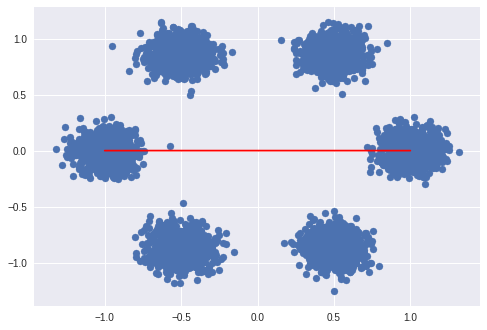

In [52]:
import matplotlib.pyplot as plt
plt.scatter(*zip(*p))
plt.plot(np.cos(inpt),[0]*len(inpt),'r')
plt.show()

In [53]:
with tf.device('/gpu:0'):
  dataset = tf.data.Dataset.from_tensor_slices( (np.expand_dims(np.array(inpt,dtype=np.float32),axis=1),  np.array(p,dtype=np.float32))).batch(256).repeat()
print(dataset)
features, labels = next(iter(dataset))
print (np.unique(features))

<RepeatDataset shapes: ((?, 1), (?, 2)), types: (tf.float32, tf.float32)>
[0.        1.0471976 2.0943952 3.1415927 4.1887903 5.2359877]


In [0]:

class pymodel(tf.keras.Model):
    def __init__(self,encoder_dim =[10],decoder_dim =[10],activation = tf.nn.relu):
      super(pymodel,self).__init__()
      with tf.device('/gpu:0'):
        
        
        self.encode_mu = tf.keras.Sequential()
        for ll in encoder_dim:
          self.encode_mu.add(tf.keras.layers.Dense(units=ll,activation=activation))
          self.encode_mu.add(tf.keras.layers.BatchNormalization())
          
      
        self.encode_logvar = tf.keras.Sequential()
        for ll in encoder_dim:
          self.encode_logvar.add(tf.keras.layers.Dense(units=ll,activation=activation))
          self.encode_mu.add(tf.keras.layers.BatchNormalization())
        
        self.decoder= tf.keras.Sequential()
        for ll in decoder_dim:
            self.decoder.add(tf.keras.layers.Dense(units=ll,activation=tf.nn.tanh))
            self.encode_mu.add(tf.keras.layers.BatchNormalization())
                                         
        self.outlayer = tf.keras.layers.Dense(units=2)
    
    
    def get_latent(self,input):
      mu = self.encode_mu(input)
      log_var = self.encode_logvar(input)
      return mu,log_var
    
    def decode(self,z):
      return self.outlayer(self.decoder(z))
    
    def add_noise(self,mu,log_var):
      with tf.device('/gpu:0'):
        return mu + tf.exp(log_var / 2) *  tf.random_normal(tf.shape(mu)) #tf.shape(mu)
      
    def cond_latent(self,input):
      z_mu,z_log_var = model.get_latent(input)
      z = self.add_noise(z_mu,z_log_var)
      return tf.concat([input,z],axis=1),z_mu,z_log_var
    
    def call(self, input):
      """Actually runs the model."""
      #mu,log_var = self.get_latent(input)
      #z = self.add_noise(mu,log_var)
      #return self.decode(z)
      x,_,_ =self.cond_latent(input)
      return self.decode(x)
    
    def noise_free(self, input):
      """Actually runs the model."""
      mu,log_var = self.get_latent(input)
      #z = self.add_noise(mu,log_var)
      return self.decode(tf.concat([input,mu],axis=1))
      
    
    
    
   
    
 
model =pymodel(encoder_dim = [4,16],decoder_dim = [4])
model.get_latent = tf.contrib.eager.defun(model.get_latent) 
model.add_noise = tf.contrib.eager.defun(model.add_noise) 
model.decode = tf.contrib.eager.defun(model.decode) 
#model =tf.contrib.eager.defun(pymodel)  

In [96]:
def lossF(model,features,labels):
  with tf.device('/gpu:0'):
    #z_mu,z_log_var = model.get_latent(features)
    #out = model.decode(model.add_noise(z_mu,z_log_var))
    x,z_mu,z_log_var = model.cond_latent(features)
    out =model.decode(x)
    mse = tf.losses.mean_squared_error(labels=labels,predictions=out)
    kl = 0.5 * tf.reduce_mean(tf.exp(z_log_var) + z_mu**2 - 1. - z_log_var)
    #kl = tf.reduce_mean(tf.exp(z_log_var))
    return mse + .001*kl
  
lossF  =tf.contrib.eager.defun(lossF)  
print ( lossF(model,features,labels))

tf.Tensor(1.36281, shape=(), dtype=float32)


In [97]:
#def grad(model, inputs, targets):
 # with tf.GradientTape() as tape:
#    loss_value = lossF(model,inputs,targets)
#  return tape.gradient(loss_value, model.variables)

#print ( grad(model,features,labels))
print(features.shape[0])

256


In [0]:
with tf.device('/gpu:0'):
  solver = tf.train.AdamOptimizer()
#solver.minimize = tf.contrib.eager.defun(solver.minimize)

In [99]:
for i in range(int(5e3)):
  #grads = grad(model,features,labels)
  #solver.apply_gradients(zip(grads, model.variables),
  #                          global_step=tf.train.get_or_create_global_step())
  solver.minimize(lambda: lossF(model,features,labels),global_step =tf.train.get_or_create_global_step())
  
  if i%int(5000/int(features.shape[0])) == 0:
    print ("Loss at step {:06d}: {:.5f}".format(i, lossF(model, features, labels)))

  

Loss at step 000000: 1.30364
Loss at step 000019: 1.33145
Loss at step 000038: 0.99152
Loss at step 000057: 1.01362
Loss at step 000076: 0.92268
Loss at step 000095: 0.75761
Loss at step 000114: 0.69997
Loss at step 000133: 0.63507
Loss at step 000152: 0.67258
Loss at step 000171: 0.58057
Loss at step 000190: 0.51371
Loss at step 000209: 0.54399
Loss at step 000228: 0.50391
Loss at step 000247: 0.49665
Loss at step 000266: 0.46759
Loss at step 000285: 0.46275
Loss at step 000304: 0.43599
Loss at step 000323: 0.42285
Loss at step 000342: 0.39801
Loss at step 000361: 0.37865
Loss at step 000380: 0.35792
Loss at step 000399: 0.35677
Loss at step 000418: 0.32039
Loss at step 000437: 0.29865
Loss at step 000456: 0.27825
Loss at step 000475: 0.26547
Loss at step 000494: 0.24286
Loss at step 000513: 0.22571
Loss at step 000532: 0.21696
Loss at step 000551: 0.20865
Loss at step 000570: 0.20662
Loss at step 000589: 0.21019
Loss at step 000608: 0.18526
Loss at step 000627: 0.17220
Loss at step 0

In [100]:
print(i)

4999


In [101]:
w= np.random.randint(low = 0,high = n,size =[5000,1]).astype(np.float32) * 2 * np.pi/n
print(w.shape),print(np.unique(w))

(5000, 1)
[0.        1.0471976 2.0943952 3.1415927 4.1887903 5.235988 ]


(None, None)

In [0]:
y = model(tf.constant(w))


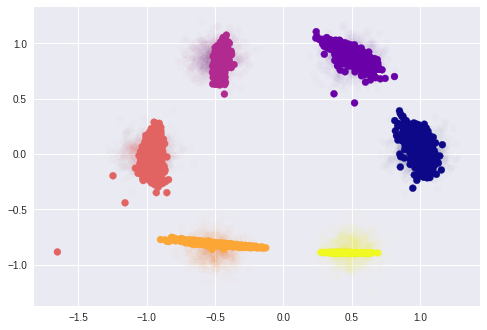

In [103]:

z =draw_data(w)
plt.scatter(z[0,:],z[1,:],c=w,cmap = "plasma",alpha=0.01)
ax = plt.scatter(y[:,0],y[:,1],c=w.flatten(),cmap = "plasma")


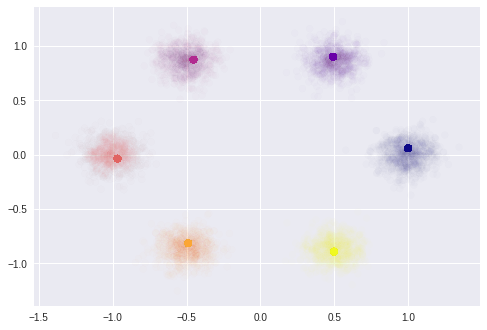

In [104]:
z =draw_data(w)
mx= model.noise_free(tf.constant(w))
plt.scatter(z[0,:],z[1,:],c=w,cmap = "plasma",alpha=0.01)
plt.scatter(mx[:,0],mx[:,1],c=w.flatten(),cmap = "plasma")


In [105]:
print (np.exp(np.unique(lv/2)))

NameError: ignored

In [104]:
for i in range(10):
  print (model(tf.constant(np.atleast_2d(0),dtype=tf.float32)).numpy())

[[ 0.55131656 -0.9478506 ]]
[[ 0.5044454 -0.9460045]]
[[ 0.41591138 -0.81656647]]
[[ 0.5426252 -0.9476866]]
[[ 0.55624676 -0.9478316 ]]
[[ 0.50837183 -0.9473778 ]]
[[ 0.55125654 -0.9479747 ]]
[[ 0.84181654 -1.0212758 ]]
[[ 0.5537389  -0.94825906]]
[[ 0.5494041 -0.9482143]]
